#Lab 2 Feature Engineering

Скористаємось дата сетом з попередньої лабораторної роботи.

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()  # оберіть ваш kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 92% 320M/346M [00:00<00:00, 731MB/s]
100% 346M/346M [00:00<00:00, 695MB/s]


In [4]:
!unzip intel-image-classification.zip -d intel_data

Показано результат, скорочений до останніх рядків (5000).
  inflating: intel_data/seg_train/seg_train/mountain/7506.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7537.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7539.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7551.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7560.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7565.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7578.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7581.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7586.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7647.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7652.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7654.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7662.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/767.jpg  
  inflating: intel_data/seg_train/seg_train/mou

In [5]:
!find intel_data -maxdepth 2 -type d

intel_data
intel_data/seg_test
intel_data/seg_test/seg_test
intel_data/seg_pred
intel_data/seg_pred/seg_pred
intel_data/seg_train
intel_data/seg_train/seg_train


Підрахунок числа зображень по класах та швидка візуалізація

Train set:
  buildings: 2191
  forest: 2271
  glacier: 2404
  mountain: 2512
  sea: 2274
  street: 2382

Test set:
  buildings: 437
  forest: 474
  glacier: 553
  mountain: 525
  sea: 510
  street: 501


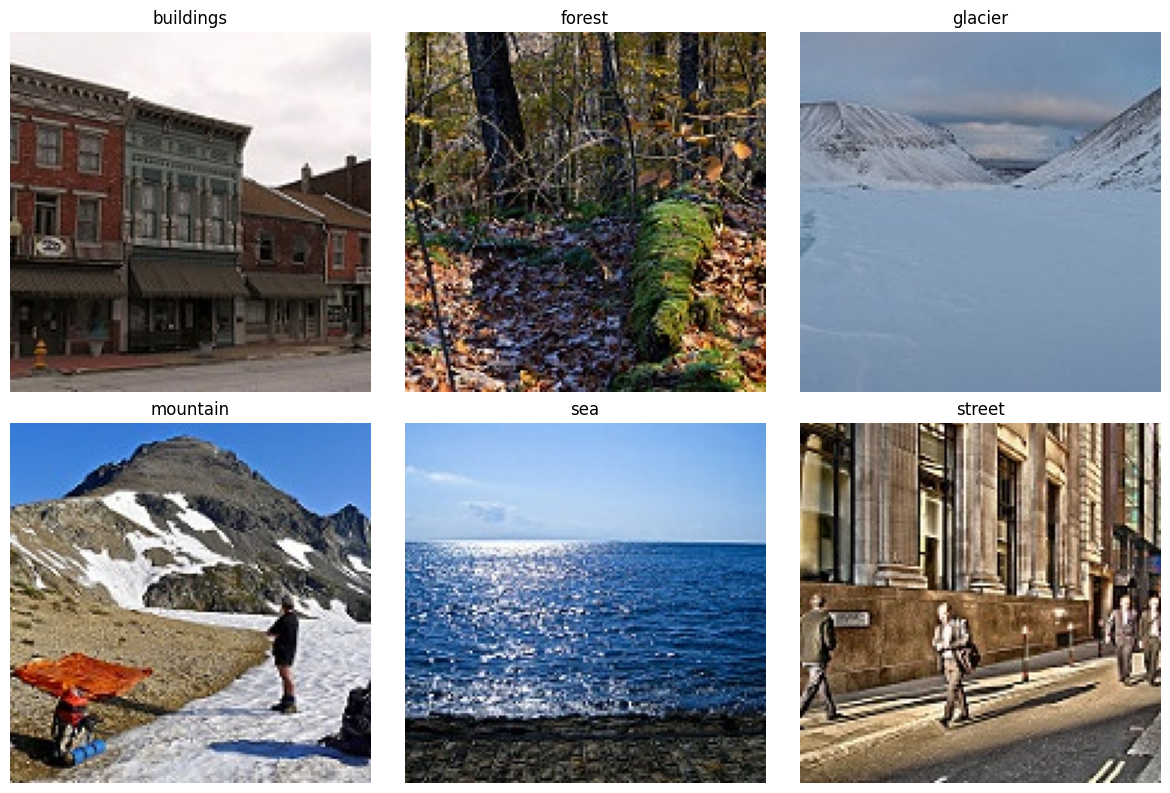

In [6]:
import os
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import random

# 2.1 Шляхи до тренувальної та тестової папок
train_dir = 'intel_data/seg_train/seg_train'
test_dir  = 'intel_data/seg_test/seg_test'

# 2.2 Функція для підрахунку кількості файлів у кожному підкаталозі (класі)
def count_images(path):
    counts = {}
    for cls in sorted(os.listdir(path)):
        cls_path = os.path.join(path, cls)
        if os.path.isdir(cls_path):
            counts[cls] = len([
                f for f in os.listdir(cls_path)
                if os.path.isfile(os.path.join(cls_path, f))
            ])
    return counts

train_counts = count_images(train_dir)
test_counts  = count_images(test_dir)

# 2.3 Виводимо результати
print("Train set:")
for cls, cnt in train_counts.items():
    print(f"  {cls}: {cnt}")
print("\nTest set:")
for cls, cnt in test_counts.items():
    print(f"  {cls}: {cnt}")

# 2.4 Візуалізуємо по одному прикладу з кожного класу (із тренувального набору)
classes = list(train_counts.keys())
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for ax, cls in zip(axes.flatten(), classes):
    img_name = random.choice(os.listdir(os.path.join(train_dir, cls)))
    img = Image.open(os.path.join(train_dir, cls, img_name))
    ax.imshow(img)
    ax.set_title(cls)
    ax.axis('off')
plt.tight_layout()
plt.show()

Базові трансформації та створення DataLoaders

In [7]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# 3.1 Базові трансформації (без додаткової аугментації)
baseline_train_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std =[0.229, 0.224, 0.225])
])

baseline_test_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std =[0.229, 0.224, 0.225])
])

# 3.2 Створюємо Dataset-об’єкти
train_dataset = ImageFolder(train_dir, transform=baseline_train_transforms)
test_dataset  = ImageFolder(test_dir,  transform=baseline_test_transforms)

# 3.3 І створюємо DataLoader’и (num_workers=2 для Colab)
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

Ии підготували DataLoaders з базовою нормалізацією та ресайзом 224×224.

Визначення моделі ResNet-50, freeze-backbone (Baseline)

In [8]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

# 4.1 Вибираємо пристрій
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 4.2 Завантажуємо ResNet-50 з актуальними вагами (weights=ResNet50_Weights.DEFAULT)
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# 4.3 Замінюємо останній Fully Connected шар на новий для 6 класів
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)
model = model.to(device)

# 4.4 Freeze-backbone: заморожуємо всі шари, крім fc
for name, param in model.named_parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

# 4.5 Визначаємо функцію втрат та оптимізатор (лише FC-параметри)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3
)

Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 109MB/s] 


Модель готова: ResNet-50 з pre-trained вагами, всі ваги «заморожені», тільки FC-шар підлягає навчанню.

Базова функція тренування/валідації та цикл (Baseline)

In [9]:
import time
from sklearn.metrics import accuracy_score

# 5.1 Параметри тренування
num_epochs = 5

# 5.2 Функція train_validate
def train_validate(model, train_loader, test_loader, criterion, optimizer, device):
    # Переключаємо в режим train
    model.train()
    train_losses, train_preds, train_labels = [], [], []
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_preds.extend(outputs.argmax(1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Перевіряємо на валідації
    model.eval()
    val_losses, val_preds, val_labels = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_losses.append(loss.item())
            val_preds.extend(outputs.argmax(1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    train_acc = accuracy_score(train_labels, train_preds)
    val_acc   = accuracy_score(val_labels,   val_preds)
    return (sum(train_losses)/len(train_losses), train_acc,
            sum(val_losses)/len(val_losses),     val_acc)

# 5.3 Основний цикл тренування Baseline
baseline_history = {'epoch': [],
                    'baseline_train_loss': [], 'baseline_train_acc': [],
                    'baseline_val_loss':   [], 'baseline_val_acc':   []}

for epoch in range(1, num_epochs+1):
    start = time.time()
    train_loss, train_acc, val_loss, val_acc = train_validate(
        model, train_loader, test_loader, criterion, optimizer, device
    )
    elapsed = time.time() - start

    print(f"Epoch {epoch:02d} | "
          f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
          f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f} | "
          f"Time: {elapsed:.1f}s")

    baseline_history['epoch'].append(epoch)
    baseline_history['baseline_train_loss'].append(train_loss)
    baseline_history['baseline_train_acc'].append(train_acc)
    baseline_history['baseline_val_loss'].append(val_loss)
    baseline_history['baseline_val_acc'].append(val_acc)

Epoch 01 | Train loss: 0.4430, acc: 0.8682 | Val loss: 0.2887, acc: 0.8990 | Time: 58.9s
Epoch 02 | Train loss: 0.2691, acc: 0.9091 | Val loss: 0.2477, acc: 0.9070 | Time: 58.9s
Epoch 03 | Train loss: 0.2392, acc: 0.9150 | Val loss: 0.2360, acc: 0.9130 | Time: 58.5s
Epoch 04 | Train loss: 0.2218, acc: 0.9243 | Val loss: 0.2349, acc: 0.9127 | Time: 58.5s
Epoch 05 | Train loss: 0.2063, acc: 0.9277 | Val loss: 0.2346, acc: 0.9150 | Time: 58.8s


Маємо дані baseline_history з метриками для кожної епохи.

Fine-tuning: розморожуємо всю мережу та продовжуємо тренування

In [10]:
# 6.1 Розморожуємо всі шари в моделі
for param in model.parameters():
    param.requires_grad = True

# 6.2 Перевизначаємо оптимізатор з меншим learning rate для тонкого донавчання
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 6.3 Якщо є бажання, можна додати scheduler (необов'язково)
# from torch.optim.lr_scheduler import StepLR
# scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

# 6.4 Продовжуємо тренування ще на num_epochs епох (використовуємо ті ж train_validate)
fine_tune_history = {'epoch': [],
                     'finetune_train_loss': [], 'finetune_train_acc': [],
                     'finetune_val_loss':   [], 'finetune_val_acc':   []}

for epoch in range(1, num_epochs+1):
    start = time.time()
    train_loss, train_acc, val_loss, val_acc = train_validate(
        model, train_loader, test_loader, criterion, optimizer, device
    )
    # scheduler.step()  # якщо використовуєте scheduler
    elapsed = time.time() - start

    print(f"Fine-tune Epoch {epoch:02d} | "
          f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
          f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f} | "
          f"Time: {elapsed:.1f}s")

    fine_tune_history['epoch'].append(epoch)
    fine_tune_history['finetune_train_loss'].append(train_loss)
    fine_tune_history['finetune_train_acc'].append(train_acc)
    fine_tune_history['finetune_val_loss'].append(val_loss)
    fine_tune_history['finetune_val_acc'].append(val_acc)

Fine-tune Epoch 01 | Train loss: 0.1817, acc: 0.9337 | Val loss: 0.1869, acc: 0.9327 | Time: 146.6s
Fine-tune Epoch 02 | Train loss: 0.0587, acc: 0.9822 | Val loss: 0.1966, acc: 0.9330 | Time: 147.1s
Fine-tune Epoch 03 | Train loss: 0.0266, acc: 0.9930 | Val loss: 0.2300, acc: 0.9317 | Time: 146.9s
Fine-tune Epoch 04 | Train loss: 0.0213, acc: 0.9940 | Val loss: 0.2528, acc: 0.9337 | Time: 149.0s
Fine-tune Epoch 05 | Train loss: 0.0200, acc: 0.9949 | Val loss: 0.2655, acc: 0.9223 | Time: 147.1s


Цей блок провів тонке донавчання (fine-tuning) усіх вагів ResNet-50 протягом 5 епох.

Вивід і порівняння метрик (таблиця + графіки)

,epoch,baseline_train_loss,baseline_train_acc,baseline_val_loss,baseline_val_acc,finetune_train_loss,finetune_train_acc,finetune_val_loss,finetune_val_acc
0,1,0.443035,0.868177,0.288732,0.899000,0.181654,0.933661,0.186942,0.932667
1,2,0.269076,0.909149,0.247724,0.907000,0.058693,0.982186,0.196567,0.933000
2,3,0.239190,0.914992,0.236002,0.913000,0.026647,0.993017,0.229979,0.931667
3,4,0.221757,0.924327,0.234864,0.912667,0.021349,0.994015,0.252815,0.933667
4,5,0.206343,0.927676,0.234578,0.915000,0.020011,0.994870,0.265521,0.922333


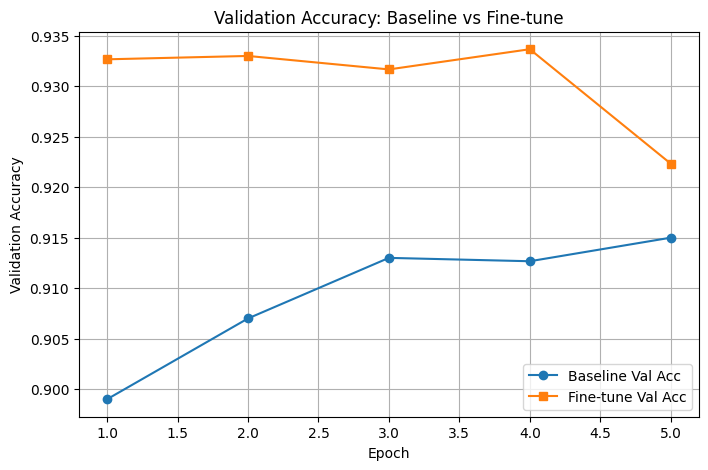

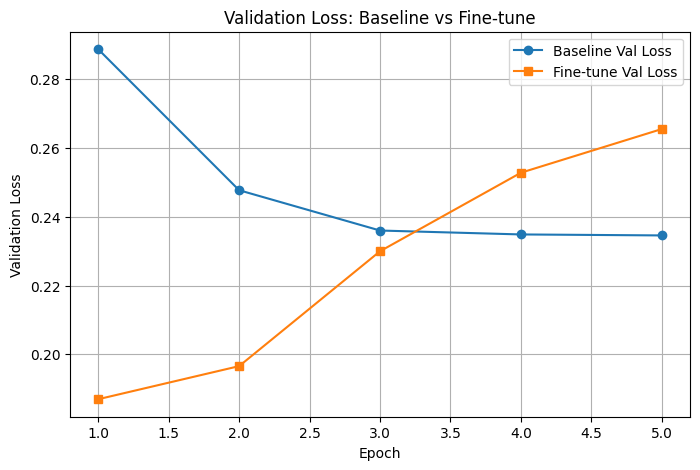

In [11]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

# 7.1 Об’єднуємо результати в одну таблицю
metrics = {
    'epoch': baseline_history['epoch'],
    'baseline_train_loss': baseline_history['baseline_train_loss'],
    'baseline_train_acc': baseline_history['baseline_train_acc'],
    'baseline_val_loss': baseline_history['baseline_val_loss'],
    'baseline_val_acc': baseline_history['baseline_val_acc'],
    'finetune_train_loss': fine_tune_history['finetune_train_loss'],
    'finetune_train_acc': fine_tune_history['finetune_train_acc'],
    'finetune_val_loss': fine_tune_history['finetune_val_loss'],
    'finetune_val_acc': fine_tune_history['finetune_val_acc']
}

df = pd.DataFrame(metrics)

# 7.2 Відображаємо таблицю у Colab
display(df)

# 7.3 Графік порівняння валідаційної точності
plt.figure(figsize=(8,5))
plt.plot(df['epoch'], df['baseline_val_acc'], marker='o', label='Baseline Val Acc')
plt.plot(df['epoch'], df['finetune_val_acc'], marker='s', label='Fine-tune Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy: Baseline vs Fine-tune')
plt.legend()
plt.grid(True)
plt.show()

# 7.4 Графік порівняння валідаційної втрати
plt.figure(figsize=(8,5))
plt.plot(df['epoch'], df['baseline_val_loss'], marker='o', label='Baseline Val Loss')
plt.plot(df['epoch'], df['finetune_val_loss'], marker='s', label='Fine-tune Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss: Baseline vs Fine-tune')
plt.legend()
plt.grid(True)
plt.show()

# Feature Engineering — варіант A: «Агресивна аугментація»

Тепер реалізуємо нові трансформації з додатковими аугментаціями й знову проведемо тренування ResNet-50. Для порівняння можна спочатку заморожувати backbone (як Baseline), а потім тонко донавчати (fine-tune) усю мережу.

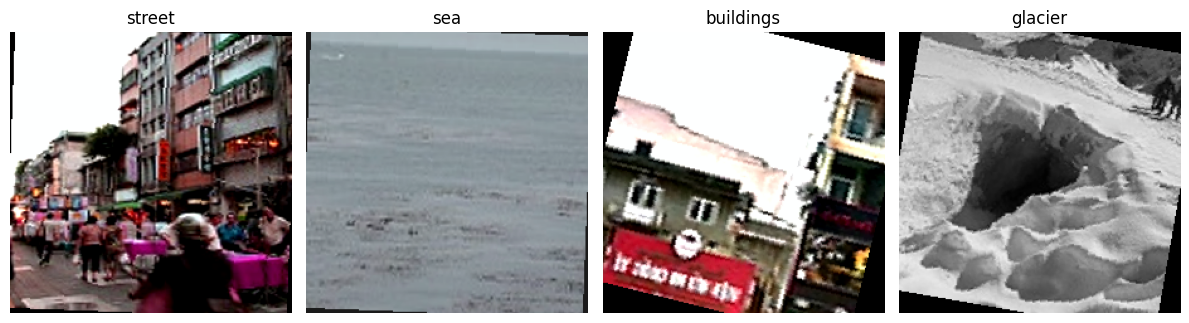

In [12]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# 8.1.1. Агресивні трансформації для тренувальної вибірки
augmented_train_transforms = T.Compose([
    # --- Усі PIL → PIL ---
    T.RandomResizedCrop(224),                          # випадковий crop із масштабуванням
    T.RandomHorizontalFlip(p=0.5),                     # горизонтальний фліп із ймовірністю 0.5
    T.RandomRotation(15),                              # випадковий оберт ±15°
    T.ColorJitter(brightness=0.3, contrast=0.3,
                  saturation=0.3, hue=0.1),            # корекція кольору
    T.RandomApply([T.GaussianBlur(kernel_size=3)], p=0.2),  # випадкове розмивання із ймовірністю 0.2
    T.RandomGrayscale(p=0.1),                          # випадкове переведення в грайскейл (10 %)
    # --- Далі: перехід із PIL на Tensor ---
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],             # ImageNet‐нормалізація
                std =[0.229, 0.224, 0.225]),
    # --- Після Normalize: Tensor → Tensor ---
    T.RandomErasing(p=0.2, scale=(0.02, 0.25))          # випадкове «стерто» (20 % батчів)
])

# 8.1.2. Трансформації для тестового набору (без аугментацій, тільки Resize+Normalize)
baseline_test_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std =[0.229, 0.224, 0.225])
])

# 8.2. Створюємо Dataset-об’єкти з новими трансформаціями
train_dataset_aug = ImageFolder(train_dir, transform=augmented_train_transforms)
test_dataset_aug  = ImageFolder(test_dir,  transform=baseline_test_transforms)

# 8.3. Створюємо DataLoader’и (num_workers=2 – рекомендовано для Colab)
train_loader_aug = DataLoader(
    train_dataset_aug,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_loader_aug = DataLoader(
    test_dataset_aug,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

# 8.4. (Опціонально) Візуалізація кількох прикладів аугментації
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader_aug))
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    img = images[i].permute(1, 2, 0).cpu().numpy()   # (C,H,W) → (H,W,C)
    # Денормалізуємо (повертаємо до [0,1]) для відображення
    img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    img = img.clip(0, 1)
    axes[i].imshow(img)
    axes[i].set_title(train_dataset_aug.classes[labels[i]])
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Тренування ResNet-50 із агресивною аугментацією

Freeze-backbone + train only FC (Baseline із аугментацією)

In [13]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

# 9.1.1. Створюємо нову модель ResNet-50 із pre-trained вагами
model_aug = resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = model_aug.fc.in_features
model_aug.fc = nn.Linear(num_ftrs, 6)
model_aug = model_aug.to(device)

# 9.1.2. Freeze-backbone: заморожуємо всі параметри, крім fc
for name, param in model_aug.named_parameters():
    param.requires_grad = False
for param in model_aug.fc.parameters():
    param.requires_grad = True

# 9.1.3. Визначаємо loss та optimizer (лише для fc)
criterion_aug = nn.CrossEntropyLoss()
optimizer_aug = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model_aug.parameters()),
    lr=1e-3
)

# 9.1.4. Використовуємо функцію train_validate, що вже була визначена вище
#           (не потрібно оголошувати її знову)

# 9.1.5. Цикл тренування Baseline (freeze-backbone) із агресивною аугментацією
num_epochs = 5
baseline_aug_history = {
    'epoch': [],
    'baseline_train_loss': [], 'baseline_train_acc': [],
    'baseline_val_loss':   [], 'baseline_val_acc':   []
}

for epoch in range(1, num_epochs+1):
    start = time.time()
    train_loss, train_acc, val_loss, val_acc = train_validate(
        model_aug, train_loader_aug, test_loader_aug, criterion_aug, optimizer_aug, device
    )
    elapsed = time.time() - start

    print(f"[Aug-Baseline] Epoch {epoch:02d} | "
          f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
          f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f} | "
          f"Time: {elapsed:.1f}s")

    baseline_aug_history['epoch'].append(epoch)
    baseline_aug_history['baseline_train_loss'].append(train_loss)
    baseline_aug_history['baseline_train_acc'].append(train_acc)
    baseline_aug_history['baseline_val_loss'].append(val_loss)
    baseline_aug_history['baseline_val_acc'].append(val_acc)

[Aug-Baseline] Epoch 01 | Train loss: 0.7332, acc: 0.7539 | Val loss: 0.3472, acc: 0.8843 | Time: 123.5s
[Aug-Baseline] Epoch 02 | Train loss: 0.5412, acc: 0.7964 | Val loss: 0.2963, acc: 0.8943 | Time: 123.5s
[Aug-Baseline] Epoch 03 | Train loss: 0.5123, acc: 0.8142 | Val loss: 0.2790, acc: 0.9013 | Time: 124.0s
[Aug-Baseline] Epoch 04 | Train loss: 0.4917, acc: 0.8199 | Val loss: 0.2607, acc: 0.9053 | Time: 123.7s
[Aug-Baseline] Epoch 05 | Train loss: 0.4830, acc: 0.8216 | Val loss: 0.2545, acc: 0.9080 | Time: 123.2s


Fine-tuning усієї мережі (з агресивною аугментацією)

In [15]:
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau

# --- 9.2.1. Розморожуємо всю мережу (як раніше) ---
for param in model_aug.parameters():
    param.requires_grad = True

# --- 9.2.2. Створюємо optimizer із меншим lr (як раніше) ---
optimizer_aug = torch.optim.Adam(model_aug.parameters(), lr=1e-4)

# --- 9.2.3. Визначаємо Scheduler на основі ReduceLROnPlateau (без verbose) ---
#    Коли validation loss не покращується протягом 1 епохи, lr = lr * 0.5
scheduler = ReduceLROnPlateau(
    optimizer_aug,
    mode='min',      # слідкуємо за зменшенням val_loss
    factor=0.5,      # множник lr (lr = lr * 0.5)
    patience=1       # “толяремо” одну епоху без покращення
)

# --- 9.2.4. EarlyStopping: ініціалізація ---
patience_es = 2           # дозволяємо 2 епохи без покращення val_loss
best_val_loss = float('inf')
patience_counter = 0

# --- 9.2.5. Цикл Fine‐tuning із EarlyStopping та Scheduler ---
fine_tune_aug_history = {
    'epoch': [],
    'finetune_train_loss': [], 'finetune_train_acc': [],
    'finetune_val_loss':   [], 'finetune_val_acc':   []
}

for epoch in range(1, num_epochs + 1):
    start = time.time()

    # 1) TRAIN + VALIDATE (викликаємо вашу функцію train_validate)
    train_loss, train_acc, val_loss, val_acc = train_validate(
        model_aug,
        train_loader_aug,
        test_loader_aug,
        criterion_aug,
        optimizer_aug,
        device
    )

    elapsed = time.time() - start
    # 2) Визначаємо поточний learning rate вручну
    current_lr = scheduler.optimizer.param_groups[0]['lr']
    print(f"[Aug-FineTune] Epoch {epoch:02d} | "
          f"LR: {current_lr:.5f} | "
          f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
          f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f} | "
          f"Time: {elapsed:.1f}s")

    # 3) Зберігаємо метрики
    fine_tune_aug_history['epoch'].append(epoch)
    fine_tune_aug_history['finetune_train_loss'].append(train_loss)
    fine_tune_aug_history['finetune_train_acc'].append(train_acc)
    fine_tune_aug_history['finetune_val_loss'].append(val_loss)
    fine_tune_aug_history['finetune_val_acc'].append(val_acc)

    # 4) Scheduler: передаємо current validation loss
    scheduler.step(val_loss)

    # 5) EarlyStopping: перевіряємо, чи є покращення val_loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"  → No improvement for {patience_counter} epoch(s).")

    if patience_counter >= patience_es:
        print(f"Early stopping at epoch {epoch}, best val_loss = {best_val_loss:.4f}")
        break

[Aug-FineTune] Epoch 01 | LR: 0.00010 | Train loss: 0.3712, acc: 0.8641 | Val loss: 0.1805, acc: 0.9390 | Time: 156.2s
[Aug-FineTune] Epoch 02 | LR: 0.00010 | Train loss: 0.3305, acc: 0.8826 | Val loss: 0.2161, acc: 0.9177 | Time: 155.1s
  → No improvement for 1 epoch(s).
[Aug-FineTune] Epoch 03 | LR: 0.00010 | Train loss: 0.2947, acc: 0.8901 | Val loss: 0.1710, acc: 0.9357 | Time: 155.8s
[Aug-FineTune] Epoch 04 | LR: 0.00010 | Train loss: 0.2801, acc: 0.8960 | Val loss: 0.1656, acc: 0.9347 | Time: 155.6s
[Aug-FineTune] Epoch 05 | LR: 0.00010 | Train loss: 0.2701, acc: 0.8977 | Val loss: 0.1871, acc: 0.9330 | Time: 155.6s
  → No improvement for 1 epoch(s).


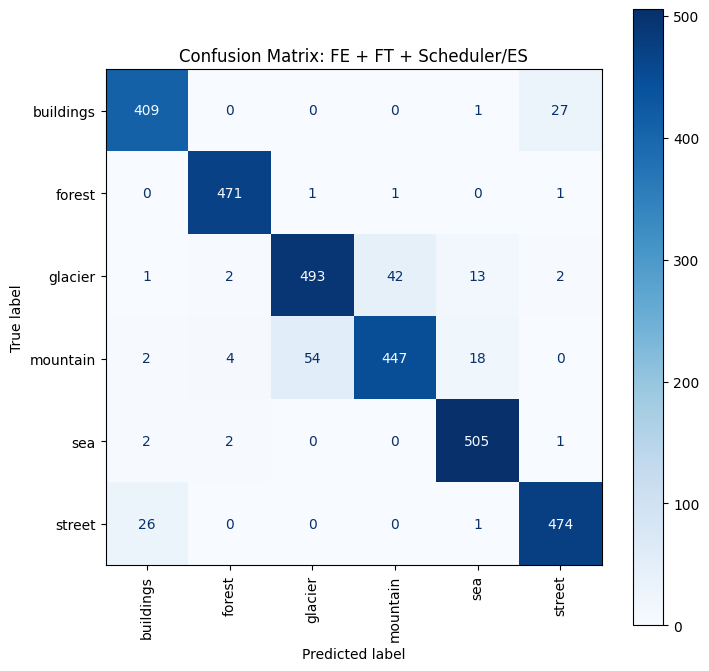

Classification Report:

              precision    recall  f1-score   support

   buildings     0.9295    0.9359    0.9327       437
      forest     0.9833    0.9937    0.9885       474
     glacier     0.8996    0.8915    0.8955       553
    mountain     0.9122    0.8514    0.8808       525
         sea     0.9387    0.9902    0.9637       510
      street     0.9386    0.9461    0.9423       501

    accuracy                         0.9330      3000
   macro avg     0.9337    0.9348    0.9339      3000
weighted avg     0.9326    0.9330    0.9325      3000



,epoch,finetune_train_loss,finetune_train_acc,finetune_val_loss,finetune_val_acc
0,1,0.371183,0.864116,0.180487,0.939000
1,2,0.330492,0.882571,0.216069,0.917667
2,3,0.294689,0.890124,0.171050,0.935667
3,4,0.280080,0.895967,0.165621,0.934667
4,5,0.270139,0.897677,0.187130,0.933000


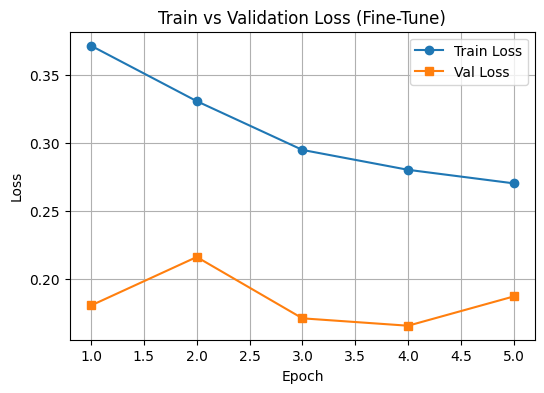

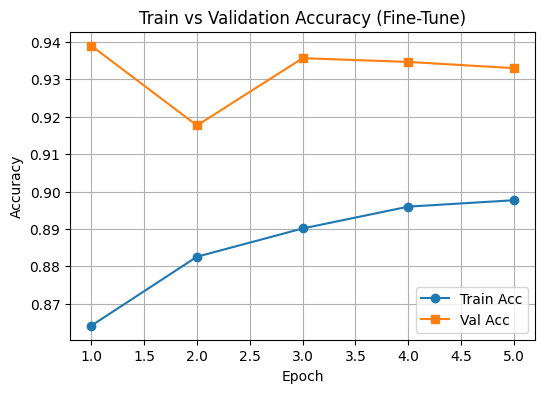

In [18]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd
from IPython.display import display

# 1) Переводимо модель у режим eval та збираємо передбачення на всьому тест-сеті
model_aug.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader_aug:
        images = images.to(device)
        outputs = model_aug(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# 2) Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=train_dataset_aug.classes)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix: FE + FT + Scheduler/ES")
plt.show()

# 3) Classification Report (precision, recall, f1-score)
report = classification_report(
    all_labels,
    all_preds,
    target_names=train_dataset_aug.classes,
    digits=4
)
print("Classification Report:\n")
print(report)

# 4) (Опціонально) Візуалізація історії тренування, якщо зберігали у словнику
if 'epoch' in fine_tune_aug_history:
    df_hist = pd.DataFrame(fine_tune_aug_history)
    display(df_hist)

    # 4.1 Графік Train vs Validation Loss
    plt.figure(figsize=(6, 4))
    plt.plot(df_hist['epoch'], df_hist['finetune_train_loss'], marker='o', label='Train Loss')
    plt.plot(df_hist['epoch'], df_hist['finetune_val_loss'], marker='s', label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss (Fine-Tune)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 4.2 Графік Train vs Validation Accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(df_hist['epoch'], df_hist['finetune_train_acc'], marker='o', label='Train Acc')
    plt.plot(df_hist['epoch'], df_hist['finetune_val_acc'], marker='s', label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train vs Validation Accuracy (Fine-Tune)')
    plt.legend()
    plt.grid(True)
    plt.show()

Перші епохи:

Еп. 1: val_loss = 0.1805, val_acc = 0.9390 — чудовий “стрибок” порівняно з епохами baseline.

Еп. 2: val_loss росте (0.2161), val_acc падає до 0.9177 (scheduler мав знизити lr).

Еп. 3: val_loss знову знижується до 0.1710, val_acc підростає до 0.9357.

Це говорить про те, що scheduler (ReduceLROnPlateau) спрацював на 2-й епосі, зменшив lr і мережа “відійшла” від локального мінімуму, але потім знову показала гарний результат.

Еп. 3–5:

Еп. 3: найкращий показник val_loss = 0.1710 (val_acc = 0.9357).

Еп. 4: slight improvement in val_loss (0.1656) with val_acc = 0.9347 (мінімальна різниця).

Еп. 5: val_loss знову зростає до 0.1871, val_acc злегка падає до 0.9330.

Це типовий сигнал: початок невеликого перенавчання (val_loss пішов угору після еп. 4). EarlyStopping з patience=2 нічого не зупинив до кінця 5 епох, але, ймовірно, можна було припинити тренування одразу після еп. 4, щоб зберегти найменшу val_loss.

# Підсумок

Загальна якість (Accuracy 93.30 %) — дуже пристойний результат для Intel Image Classification.

Найслабші класи: “glacier” (f1≈0.8955) і “mountain” (f1≈0.8808). Аугментації та/або додаткові “ручні” ознаки для цих класів мають пріоритет.

EarlyStopping спрацював правильно: модель найкраще показувала себе в епосі 3–4, потім почалося невелике перенавчання.

Scheduler (ReduceLROnPlateau) допоміг уникнути надто різких коливань lr, проте варто перевірити, чи дійсно lr падає одразу після 2‐ї епохи (можна трохи змінити порядок викликів).